In [ ]:
%pip install graphviz z3-solver

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from engine import *
from functools import partial

In [3]:
from IPython.lib.display import YouTubeVideo

# 0. Motivation

Videos and slides borrowed from [CS 521 - Advanced Topics in Programming Systems: Trustworthy AI Systems](https://courses.grainger.illinois.edu/cs521/fa2022/)

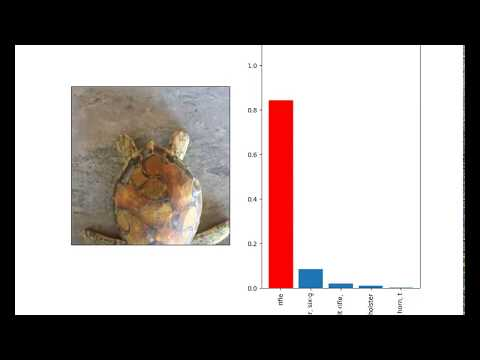

In [4]:
YouTubeVideo('YXy6oX1iNoA')

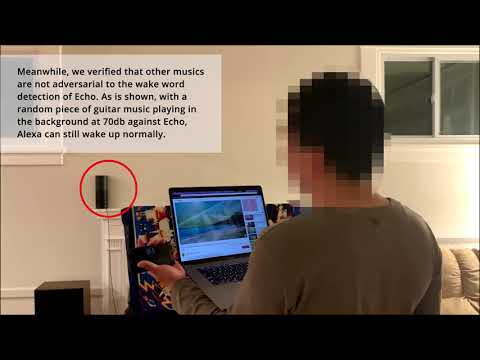

In [5]:
YouTubeVideo('r4XXGDVs0f8')

NN4Sys? even worse

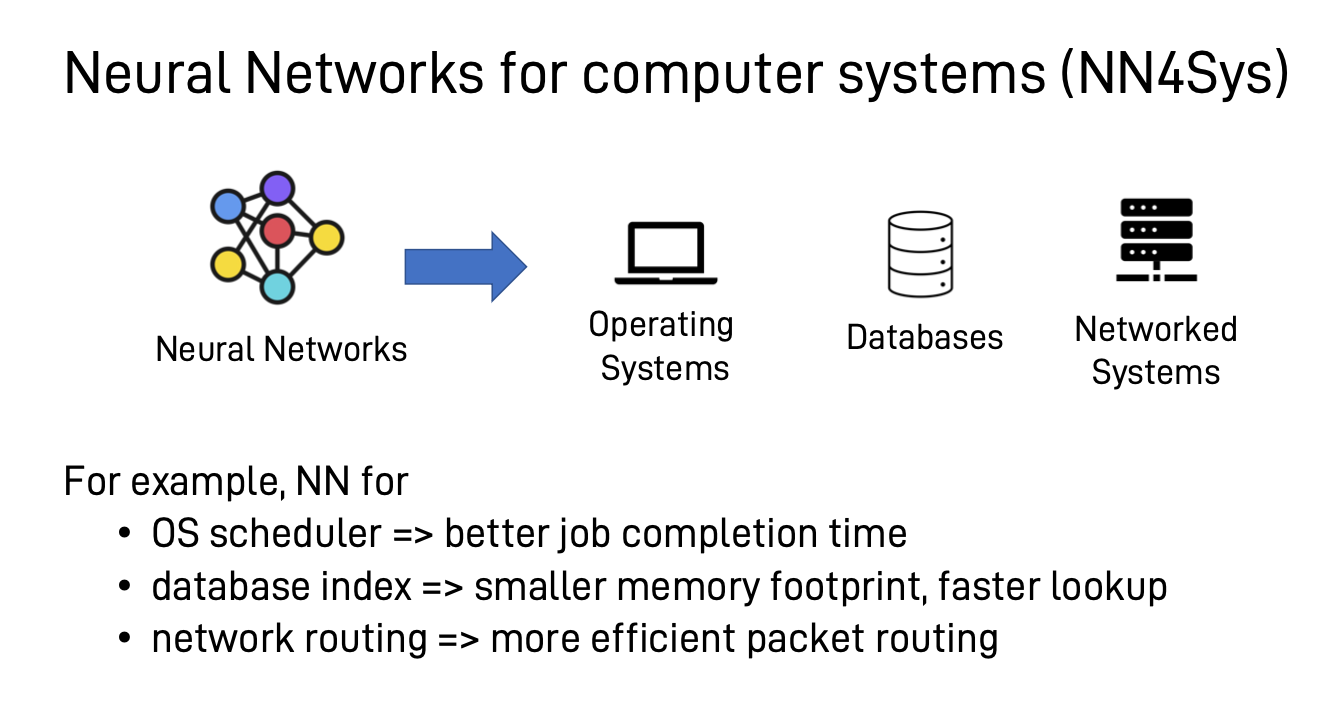

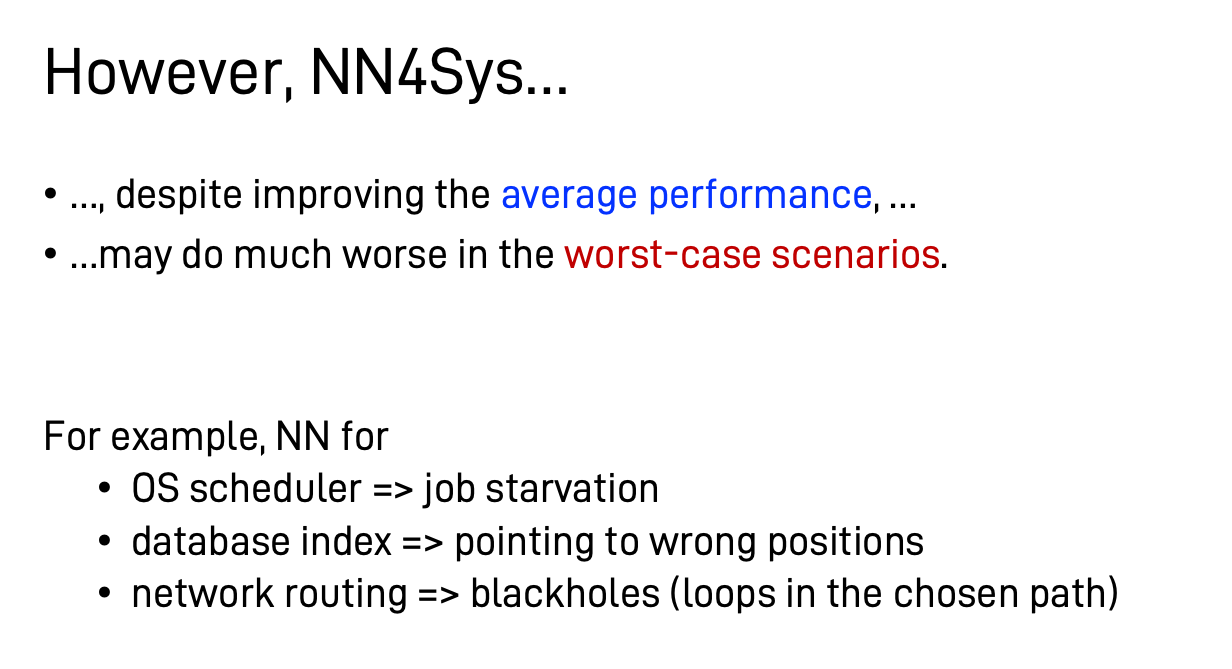

Why is it hard?

NNs are black boxes and it is hard to undertand what NNs have learned.
And, it is hard to know what are the behaviors of the NNs.

# 1. problem: NN Verification

Instead of understanding NN's behaviors, we can verify if NNs follow predefined specs.

The problem:
a trained NN + a specification => if NN satisfies spec?

## 1.1 a toy problem: distinguishing points in a circle

In [6]:
def f(x):
    assert len(x) == 2
    return 1 if x[0] ** 2 + x[1] ** 2 <= 0.25 else 0

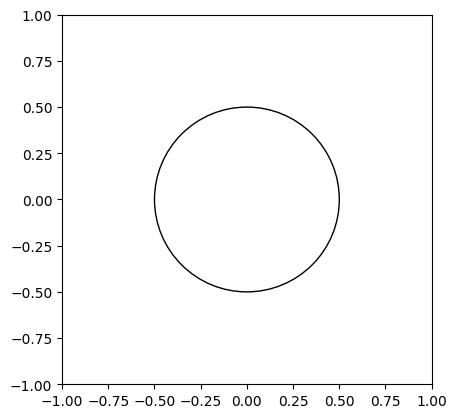

In [7]:
def draw_circle():
    plt.axes()
    circle = plt.Circle((0,0), 0.5, fc='white',ec="black")
    plt.gca().add_patch(circle)
    plt.gca().set_aspect('equal')
    plt.xlim(-1,1)
    plt.ylim(-1,1)

draw_circle()

In [8]:
def gen_data(num):
    xs = []
    for i in range(num):
        x1 = random.uniform(-1, 1)
        x2 = random.uniform(-1, 1)
        xs.append((x1, x2))
    return np.array(xs)

xs = gen_data(1000)

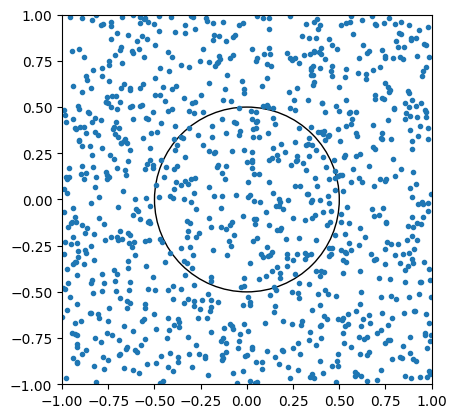

In [9]:
def draw_data(xs):
    plt.scatter([x[0] for x in xs], [x[1] for x in xs], marker='.')
    
draw_circle()
draw_data(xs)


## 1.2 define a FC neural network

In [10]:
net = MLP(2, [8, 8, 1])
print(net)
print("number of parameters", len(net.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8)], Layer of [LinearNeuron(8)]]
number of parameters 105


In [11]:
# calculate the number of parameters
2*8 + 8 + \
8*8 + 8 + \
8*1 + 1

105

In [14]:
# gd training!!
learning_rate = 0.002
rounds = 200
batch_size = 100

last_grad = {}
for i in range(rounds):
    
    indx = np.random.permutation(len(xs))[:batch_size]
    batch_xs = xs[indx]
    
    # forward pass
    pred_ys = list(map(net, batch_xs))

    # loss
    loss = sum([(pred_y - y)**2 for pred_y,y in zip(pred_ys, [f(x) for x in batch_xs])])
    
    # calculate grad
    net.zero_grad()
    loss.backward()
    
    # gd
    for p in net.parameters():
        delta = -1 * learning_rate * p.grad
        p.data += delta
    
    print(f"Round[{i}]:  loss = {loss.data}")

Round[0]:  loss = 5.873435722097124
Round[1]:  loss = 7.776844210633712
Round[2]:  loss = 6.69465244226428
Round[3]:  loss = 6.640889215268603
Round[4]:  loss = 4.105830228200284
Round[5]:  loss = 5.581742810164898
Round[6]:  loss = 7.92410375984516
Round[7]:  loss = 6.069805187667741
Round[8]:  loss = 7.765662434855089
Round[9]:  loss = 6.565445852150597
Round[10]:  loss = 5.604639717479767
Round[11]:  loss = 4.568147950574601
Round[12]:  loss = 6.572187271354328
Round[13]:  loss = 6.307694792998426
Round[14]:  loss = 7.771164801205841
Round[15]:  loss = 6.951293402897704
Round[16]:  loss = 6.755532458845949
Round[17]:  loss = 5.265142113981246
Round[18]:  loss = 5.136693574950209
Round[19]:  loss = 7.7214234553294565
Round[20]:  loss = 6.973775674555544
Round[21]:  loss = 5.192744999917565
Round[22]:  loss = 6.30598062735891
Round[23]:  loss = 7.531672647115375
Round[24]:  loss = 7.372803236932766
Round[25]:  loss = 5.489564669406261
Round[26]:  loss = 5.92011020969043
Round[27]:  lo

In [15]:
print("----within the circle----")
print(net((0,0)))
print(net((0.1,0)))
print(net((-0.1,0.1)))

print("----outside the circle----")
print(net((1,1)))
print(net((-1,1)))
print(net((1,-1)))


print("----around the boundary----")
print(net((0.51,0)))  # outside
print(net((0.25,0.25))) # inside
print(net((0,-0.49))) # inside

----within the circle----
Value(label=H-909903543864950843, data=0.9617346967079247, grad=0)
Value(label=H-909903543864950843, data=0.9551027591561085, grad=0)
Value(label=H-909903543864950843, data=0.9577982910161139, grad=0)
----outside the circle----
Value(label=H-909903543864950843, data=-0.10672758186876896, grad=0)
Value(label=H-909903543864950843, data=-0.3513188670262605, grad=0)
Value(label=H-909903543864950843, data=-0.08457752622784298, grad=0)
----around the boundary----
Value(label=H-909903543864950843, data=0.48235698689801676, grad=0)
Value(label=H-909903543864950843, data=0.7657807017692139, grad=0)
Value(label=H-909903543864950843, data=0.5019342402239294, grad=0)


## 1.3 specification

Q: what's the "expected behavior"---which we call specification---of this toy problem?

One of many can be ...

$\forall x \in ([0.2, 0.35], [0.2, 0.35]) \implies y>0.5?$

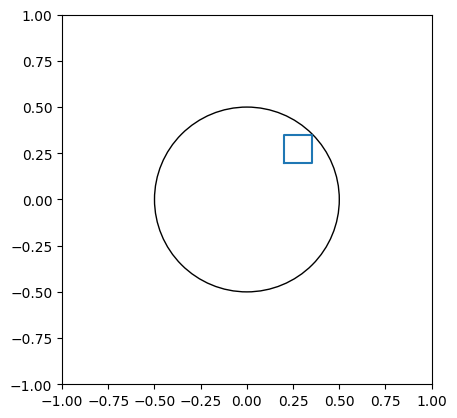

In [16]:
def draw_spec(lows, highs):
    plt.plot([lows[0], highs[0], highs[0], lows[0], lows[0]],
             [lows[1], lows[1], highs[1], highs[1], lows[1]])
    
draw_circle()
draw_spec([0.2,0.2], [0.35,0.35])

## 1.4 How do we know if spec holds?
## one approach: testing

In [17]:
def gen_test(num, lows, highs):
    xs = []
    assert lows[0] < highs[0] and lows[1] < highs[1]
    for i in range(num):
        x1 = random.uniform(lows[0], highs[0])
        x2 = random.uniform(lows[1], highs[1])
        xs.append((x1, x2))
    return np.array(xs)

def net_test(net, testing_data):
    counterexamples = []
    pred_ys = list(map(net, testing_data))
    ys = [f(x) for x in testing_data]
    for i,x in enumerate(testing_data):
        if int(pred_ys[i].data + 0.5) != int(ys[i]):
            counterexamples.append(x)
    return counterexamples
           

testing_data = gen_test(10, (0.2,0.2), (0.35,0.35))

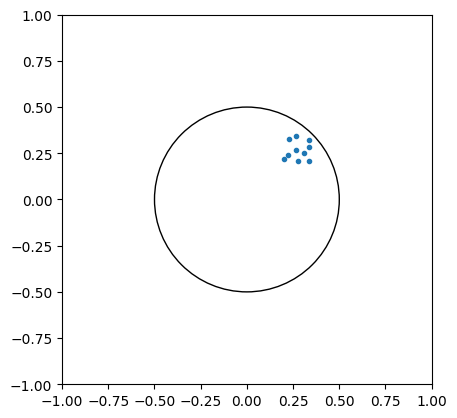

In [18]:
draw_circle()
draw_data(testing_data)

In [19]:
# testing
ret = net_test(net, testing_data)
if len(ret) == 0:
    print("Pass! no violation found.")
else:
    print("Failed! counterexamples:", ret)

Pass! no violation found.


# 2. NN verification I: using SMT slovers

We want NN verification.
By "verification", we mean the answers to the problem,

$\forall x \in ([0.2, 0.35], [0.2, 0.35]) \implies y>0.5?$

is **complete and sound**.

- **Complete**: if the NN satisfies spec, the verification accepts.
- **Sound**: if the verification accepts, the NN satisfies spec.

## 2.1 background: an SMT solver, z3

In [20]:
from z3 import *

In [21]:
x1 = Real('x1')
x2 = Real('x2')
c1 = (x1**2 + x2**2 <= 0.25)
c2 = And(x1> 0.2, x1<0.35)
c3 = And(x2> 0.2, x2<0.35)

solve([c1, c2, c3])

[x1 = 1/4, x2 = 1/4]


In [22]:
# an unsat example
x1 = Real('x1')
x2 = Real('x2')
c1 = (x1**2 + x2**2 <= 0.25)
c2 = And(x1> 0.36, x1<0.4)
c3 = And(x2> 0.36, x2<0.4)

solve([c1, c2, c3])


no solution


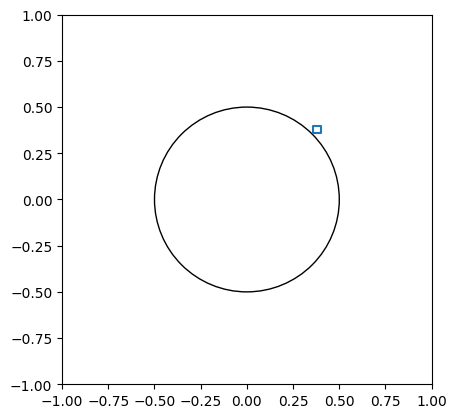

In [23]:
draw_circle()
draw_spec([0.36,0.36], [0.4,0.4])

## 2.2 encode NNs to SMT clauses

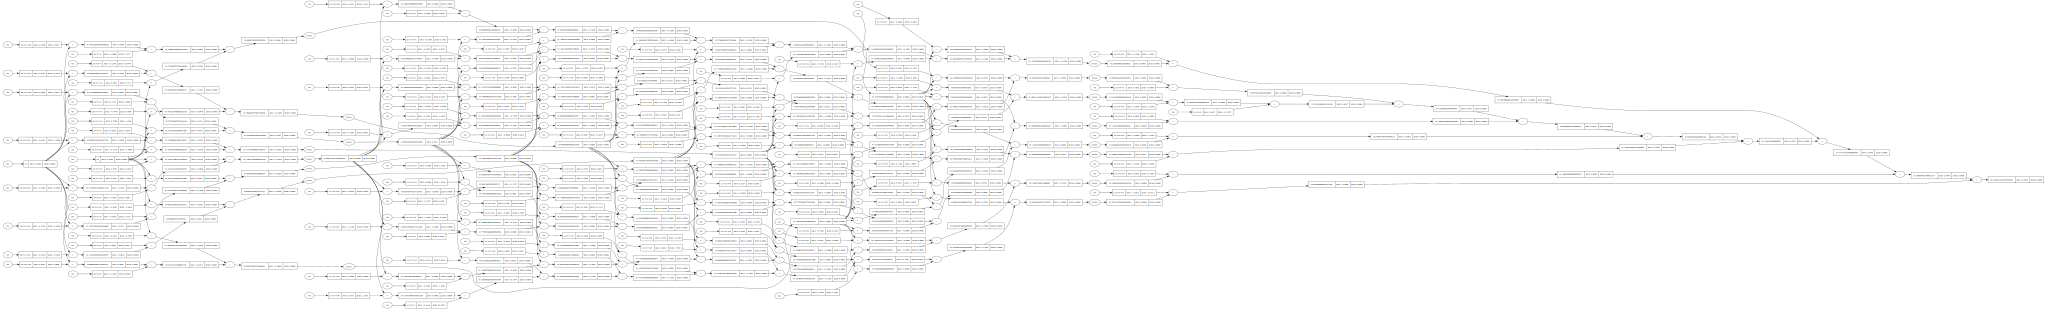

In [24]:
y = net((Value(0.1,label="x1"),Value(0.1,label="x2")))
draw_dot(y)

## idea: encode as SMT clauses

For example,

$ x_2 = ReLU (W * x_1 + b) $

can be encoded as:

- $var1 == W*x_1$
- $var2 == var1+b$
- $x_2 == if(var2>0, var2, 0)$


In [25]:
z3vars = {}  # all z3 variables
z3clauses = [] # all clauses

@add_to_class(Value)
def encode(self):
    # add myself to the z3 variables
    global z3vars
    assert self.label != "" and self.label is not None
    assert self.label not in z3vars
    self._z3var = Real(self.label)
    z3vars[self.label] = self._z3var
    if self.label[0] == "L":
        z3clauses.append(z3vars[self.label] == self.data)
    
    # check children
    for c in self._prev:
        assert c.label in z3vars
    
    # add clauses
    op = self._op
    if (op == "+") or (op == "*"):
        assert len(self._prev) == 2
        left = list(self._prev)[0]
        right = list(self._prev)[1]
        if op == "+":
            z3clauses.append(self._z3var == z3vars[left.label] + z3vars[right.label])
        else:
            z3clauses.append(self._z3var == z3vars[left.label] * z3vars[right.label])
    elif (op == "ReLU"):
        assert len(self._prev) == 1
        child = next(iter(self._prev))
        z3clauses.append(self._z3var == If(z3vars[child.label] > 0, z3vars[child.label], 0))
    elif (op == "val") or (op == "input"):
        pass
    else:
        print(f"{op} not supported")
        assert False

In [26]:
@add_to_class(Value)
def encode_tree(self):
    global z3vars, z3clauses
    z3vars = {}
    z3clauses = []
    
    # topological order all of the children in the graph
    topo = []
    visited = set()
    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
    build_topo(self)

    # encode from leaf nodes (inputs) to root (output)
    for v in topo:
        v.encode()

## the problem to check: the complement set is empty

Q: what will happen if we check

$x \in ([0.2, 0.35], [0.2, 0.35]) \implies y>0.5$?

Will get some satisfied solution.

To check $\forall x$, we need to check the complement set:
    
$\exists x \in ([0.2, 0.35], [0.2, 0.35]) \implies y<=0.5$?
    
- If there exists an answer, that means the verification **rejects**;
- otherwise, the verifiation **accepts**.

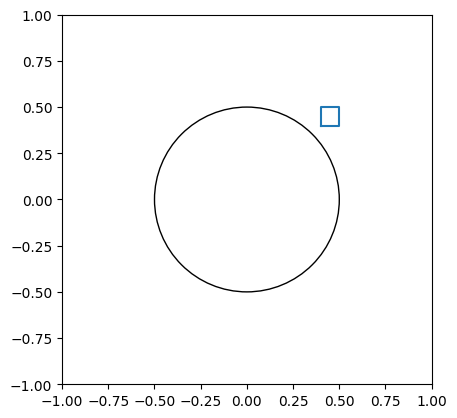

In [45]:
draw_circle()
draw_spec([0.4,0.4], [0.5,0.5])

In [46]:
y = net((Value(0.1,label="x1"),Value(0.1,label="x2")))
y.label = "y"
y.encode_tree()

# specification

# input constraints
spec1 = And(z3vars["x1"] >= 0.4, z3vars["x1"] <= 0.5)
spec2 = And(z3vars["x2"] >= 0.4, z3vars["x2"] <= 0.5)

# output constraints
spec3 = z3vars["y"] >= 0.5

z3clauses.extend([spec1, spec2, spec3])

In [47]:
solve(z3clauses)

[x2 = 27/64,
 x1 = 103/256,
 y = 32064295830248650630997892935045964050019410957151263/64000000000000000000000000000000000000000000000000000,
 H1700074921458931727 = 11500229063131976810357190021094439257368740636174351/12800000000000000000000000000000000000000000000000000,
 H-5177413572006895495 = 11500229063131976810357190021094439257368740636174351/12800000000000000000000000000000000000000000000000000,
 H-3196194283684025 = 11500229063131976810357190021094439257368740636174351/12800000000000000000000000000000000000000000000000000,
 H1405407266924861750 = 76751302114019154173219252962121292424806859775792727/80000000000000000000000000000000000000000000000000000,
 H8016803847742956475 = 9617346967079247/10000000000000000,
 H-315506492959644454 = 9617346967079247/10000000000000000,
 H3721622858121525139 = 9617346967079247/10000000000000000,
 H-9079275795969895278 = 0,
 L2-N0-W0 = -13751575021391741/250000000000000000,
 H1312228830900103630 = 0,
 H-8931111626323856107 = -100486302405648

In [48]:
# check if the counter example is indeed
x2 = 27/64
x1 = 103/256

net((x1,x2))

Value(label=H-909903543864950843, data=0.5010046223476352, grad=0)

# 3. NN verification II: reachability approach

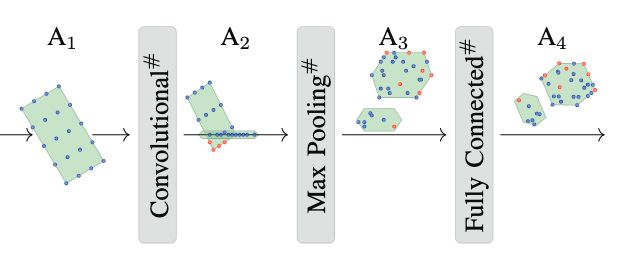

Borrowed from AI2 paper, Fig2

## 3.1. Using Box analysis

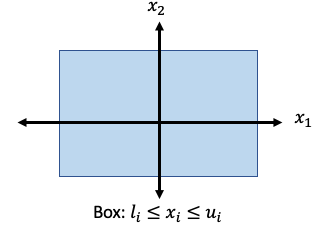

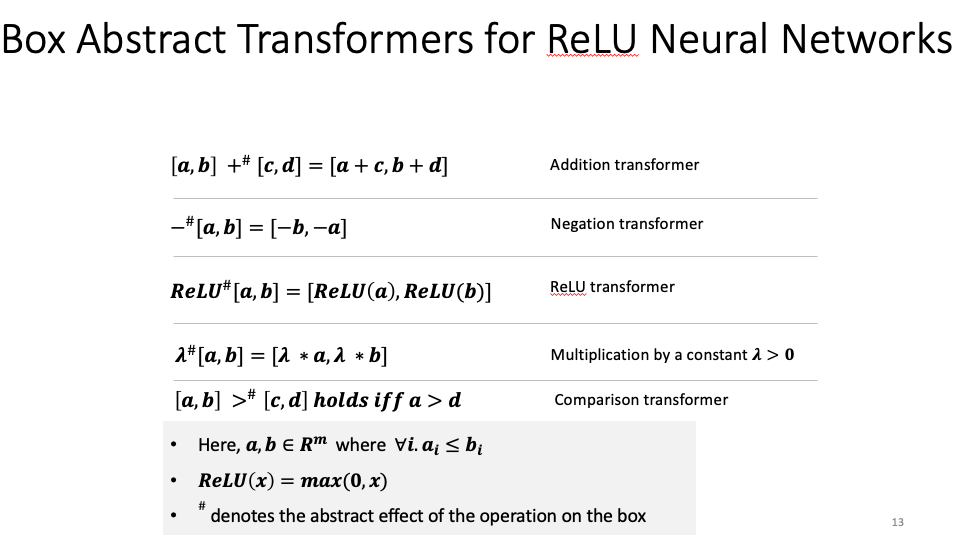

In [49]:
@add_to_class(Value)
def add_bound(self, low, high):
    self._low = low
    self._high = high

In [50]:
@add_to_class(Value)
def calc_bound(self):
    op = self._op
    if (op == "+") or (op == "*"):
        assert len(self._prev) == 2
        left = list(self._prev)[0]
        right = list(self._prev)[1]
        if op == "+":
            self.add_bound(left._low + right._low, left._high + right._high)
        else:
            left_is_constant = (left._low == left._high)
            right_is_constant = (right._low == right._high)
            assert left_is_constant or right_is_constant
            
            bound1 = left._low * right._low
            bound2 = left._high * right._high
            
            self.add_bound(min(bound1, bound2), max(bound1, bound2))
    elif (op == "ReLU"):
        assert len(self._prev) == 1
        child = next(iter(self._prev))
        
        def relu(x):
            return x if x > 0 else 0
        
        self.add_bound(relu(child._low), relu(child._high))
    elif (op == "val"):
        self.add_bound(self.data, self.data)
    elif (op == "input"):
        pass
    else:
        print(f"{op} not supported")
        assert False

In [51]:
@add_to_class(Value)
def propgate_bound(self):
    # topological order all of the children in the graph
    topo = []
    visited = set()
    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
    build_topo(self)

    # encode from beginning
    for v in topo:
        v.calc_bound()

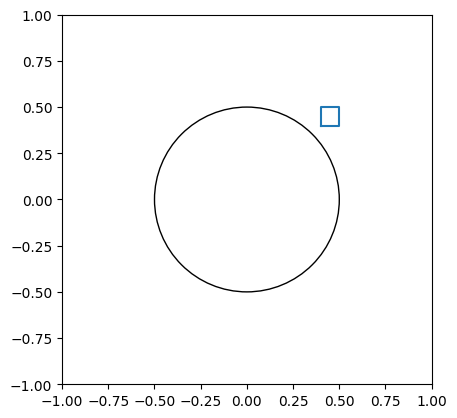

In [52]:
draw_circle()
draw_spec([0.4,0.4], [0.5,0.5])

In [53]:
x1 = Value(0.45,label="x1", _op="input")
x2 = Value(0.45,label="x2", _op="input")
x1.add_bound(0.4, 0.5)
x2.add_bound(0.4, 0.5)

y = net((x1,x2))
y.label = "y"
y.propgate_bound()


# output constraints
print(f"y({y.data}) in [{y._low},{y._high}]")
# spec: y < 0.5

y(0.439434467622431) in [0.2923450500447049,0.6074118162047111]


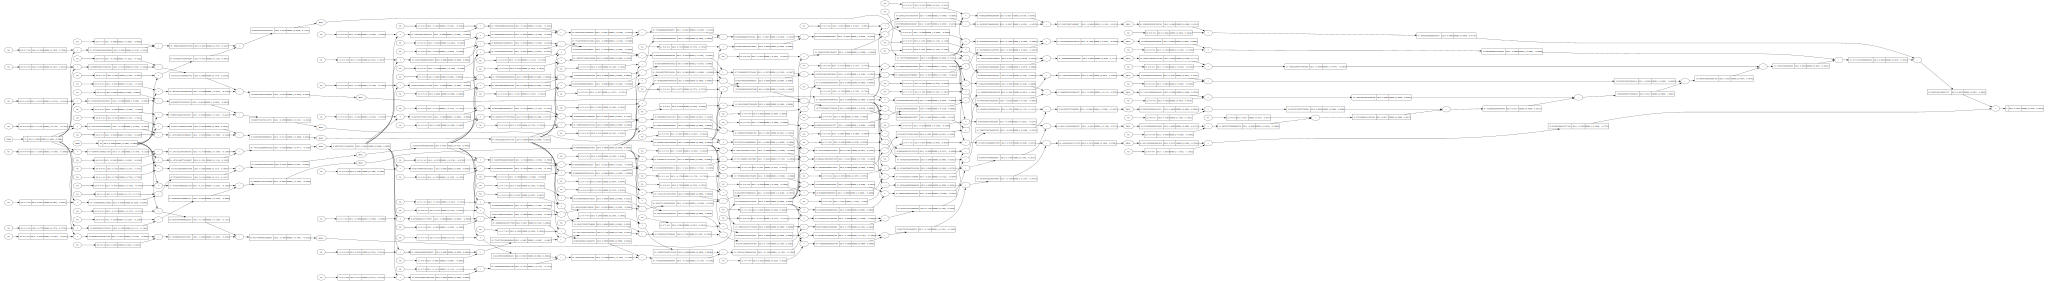

In [54]:
draw_bound(y)

## Q: are we done? What if the bound includes the y_spec?

## 3.2 idea: refine boxes

We can iteratively split the box into smaller pieces for better accuracy.

In [55]:
# spec
x1_spec = [0.4, 0.5]
x2_spec = [0.4, 0.5]
y_spec = 0.5 # <y_spec

In [62]:
def check_bound(x1_spec, x2_spec, y_spec):
    mid_x1 = (x1_spec[0]+x1_spec[1])/2
    mid_x2 = (x2_spec[0]+x2_spec[1])/2
    x1 = Value(mid_x1, label="x1", _op="input")
    x2 = Value(mid_x2, label="x2", _op="input")
    x1.add_bound(x1_spec[0], x1_spec[1])
    x2.add_bound(x2_spec[0], x2_spec[1])

    y = net((x1,x2))
    y.label = "y"
    y.propgate_bound()
    
    # check if <y_spec
    if y._high < y_spec:
        return "verified", _
    else: # what we want is "<y_spec", so a counterexample is the other way around
        if y.data >= y_spec:
            return "failed", (mid_x1, mid_x2)
        else:
            return "undefined", (mid_x1, mid_x2)
        
        
def verify(x1_spec, x2_spec, y_spec):
    x1_bounds = [x1_spec]
    x2_bounds = [x2_spec]
    
    while len(x1_bounds) > 0:
        spec1 = x1_bounds.pop(0)
        spec2 = x2_bounds.pop(0)
        ret,mid_x = check_bound(spec1, spec2, y_spec)
        
        if ret == "failed":
            return "failed", mid_x
        elif ret == "undefined":
            x1_bounds.extend([ [spec1[0],mid_x[0]], [spec1[0],mid_x[0]], [mid_x[0],spec1[1]], [mid_x[0],spec1[1]] ])
            x2_bounds.extend([ [spec2[0],mid_x[1]], [mid_x[1],spec2[1]], [spec2[0],mid_x[1]], [mid_x[1],spec2[1]] ])
            
    return "verified", _


In [63]:
ret,counterexample = verify(x1_spec, x2_spec, y_spec)

print(ret)
print(counterexample)

failed
(0.41250000000000003, 0.41250000000000003)


In [64]:
# inference to see if the counterexample is correct
net((0.41250000000000003, 0.41250000000000003))


Value(label=H-909903543864950843, data=0.5006243865249527, grad=0)

In [ ]:
MIP solver
reachability 